In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polyfeat_imp import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


# Classification

## Pointwise features

In [4]:
import sklearn 
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [5]:
rscl_df = pd.DataFrame(rscl_data, 
                       columns=[F'feat{i+1}' for i in range(len(rscl_data[0]+1))])
rscl_df.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,feat40,...,feat261,feat262,feat263,feat264,feat265,feat266,feat267,feat268,feat269,feat270,feat271,feat272,feat273,feat274,feat275,feat276,feat277,feat278,feat279,feat280,feat281,feat282,feat283,feat284,feat285,feat286,feat287,feat288,feat289,feat290,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299,feat300
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0.012752,0.011716,0.010124,0.008314,0.006670,0.005512,0.004990,0.005112,0.005866

In [6]:
X_train_ts , X_test_ts, y_train_ts, y_test_ts = train_test_split(rscl_data, params['stencil_type'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [7]:
basemodel_ts = RandomForestClassifier(oob_score=True, n_jobs=-1)


In [8]:
basemodel_ts.fit(X_train_ts, y_train_ts)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
bm_pred_ts = basemodel_ts.predict(X_test_ts)
f1_score(y_test_ts, bm_pred_ts, average='weighted')

0.9814926420491864

In [ ]:
scores_ts = cross_val_score(basemodel_ts, rscl_data, params['stencil_type'], cv=5, scoring='f1_weighted', n_jobs=-1)

In [ ]:
scores_ts

array([0.97476795, 0.98004005, 0.9757538 , 0.97954517, 0.97234589])

In [10]:
print('OOB Score: ', basemodel_ts.oob_score_)

OOB Score:  0.974047619047619


     feature        fi
49    feat50  0.025749
46    feat47  0.024252
51    feat52  0.022322
47    feat48  0.020765
50    feat51  0.020640
52    feat53  0.016466
45    feat46  0.014956
280  feat281  0.014734
48    feat49  0.014460
277  feat278  0.012748


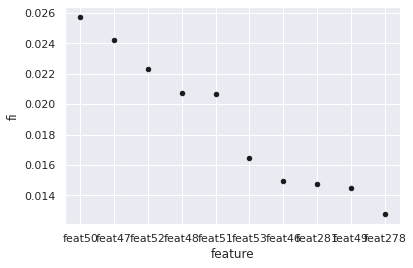

In [11]:
fi_ts = get_fi(basemodel_ts, rscl_df,'timeseries')
fi_ts[:10].plot.scatter('feature', 'fi', color='k')
print(fi_ts[:10])

In [12]:
ts_fi_data = features_vs_f1(rscl_df, 'timeseries', y=params['stencil_type'], 
               model=basemodel_ts, test_size=0.2, cv=5, niters=10, stratify=params['stencil_type'])

Running iter 1
Number of features: 300
Size of training and test set: ((8400, 300), (2100, 300))
Computing cross-validation scores
Cross val-scores: 0.97 +- 0.00314
Done! 
 Fitting model
Model Out-of-Bag score: 0.975
Test score: 0.982

Running iter 2
Number of features: 150
Size of training and test set: ((8400, 150), (2100, 150))
Computing cross-validation scores
Cross val-scores: 0.972 +- 0.0026
Done! 
 Fitting model
Model Out-of-Bag score: 0.978
Test score: 0.982

Running iter 3
Number of features: 75
Size of training and test set: ((8400, 75), (2100, 75))
Computing cross-validation scores
Cross val-scores: 0.969 +- 0.00326
Done! 
 Fitting model
Model Out-of-Bag score: 0.972
Test score: 0.979

Running iter 4
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.964 +- 0.00362
Done! 
 Fitting model
Model Out-of-Bag score: 0.969
Test score: 0.973

Running iter 5
Number of features: 19
Size of training and t

In [13]:
niters_ts = 10
nfeats_ts = [ts_fi_data[i][0] for i in range(niters_ts)]
cv_scores_ts_mean = [ts_fi_data[i][4][0] for i in range(niters_ts)]
cv_scores_ts_std = [ts_fi_data[i][4][1] for i in range(niters_ts)]
oob_scores_ts = [ts_fi_data[i][5] for i in range(niters_ts)]
test_scores_ts = [ts_fi_data[i][6] for i in range(niters_ts)]

ts_reg_results = [nfeats_ts,cv_scores_ts_mean, cv_scores_ts_std, oob_scores_ts, test_scores_ts ]

In [14]:
fi_ts = pd.DataFrame(np.array([nfeats_ts, cv_scores_ts_mean,
                       cv_scores_ts_std, oob_scores_ts, test_scores_ts]).T,
             columns=['n_feats', 'cv_mean', 'cv_std', 'oob_score', 'test_score'])

fi_ts.head()

,n_feats,cv_mean,cv_std,oob_score,test_score
0,300.0,0.970497,0.003142,0.975238,0.981905
1,150.0,0.972376,0.002602,0.977619,0.981905
2,75.0,0.968560,0.003264,0.972381,0.978571
3,38.0,0.963690,0.003621,0.969286,0.972857
4,19.0,0.952896,0.007715,0.959643,0.963810


In [15]:
nfeats_ts

[300, 150, 75, 38, 19, 10, 5, 3, 2, 1]

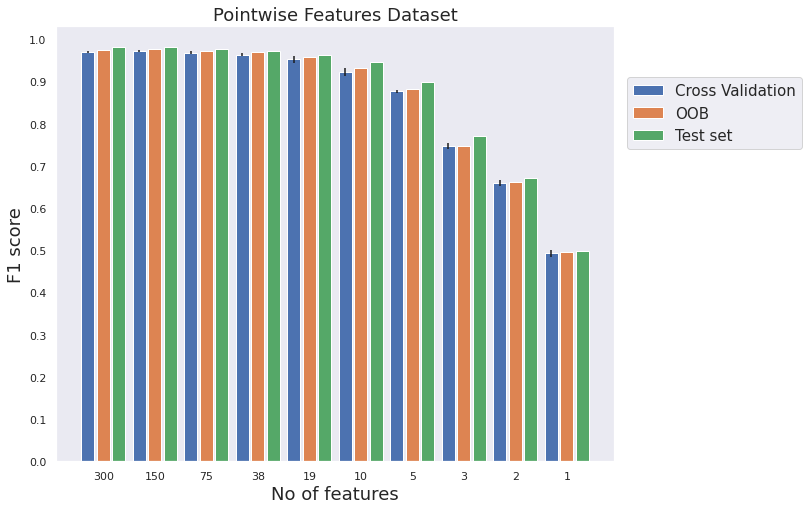

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

X = [str(i) for i in nfeats_ts]
ax.bar(x=np.arange(len(X))-0.3, height=cv_scores_ts_mean,
       yerr=cv_scores_ts_std, width=0.25, label='Cross Validation' )
ax.bar(x=np.arange(len(X)), height=oob_scores_ts, width=0.25, label='OOB' )
ax.bar(x=np.arange(len(X))+0.3, height=test_scores_ts, width=0.25, label='Test set' )

plt.xticks(np.arange(len(X)), X)
plt.xlabel("No of features", fontsize=18)
plt.ylabel("F1 score", fontsize=18)
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Pointwise Features Dataset", fontsize=18)

plt.legend(bbox_to_anchor=[1.01,0.9], prop={'size':15})
plt.grid()
plt.show()

In [17]:
print(ts_fi_data[-2][1]) 
print()
print(ts_fi_data[-1][1])

0     feat51
1    feat255
Name: feature, dtype: object

0    feat51
Name: feature, dtype: object


## Polynomial features

In [18]:
%time polyfeat = poly_featextract(rscl_data, n_splits=[4,5,10], order_fits=[3,3,3], as_df=True)

CPU times: user 23.7 s, sys: 236 ms, total: 23.9 s
Wall time: 23.7 s


In [19]:
X_train_pf , X_test_pf, y_train_pf, y_test_pf = train_test_split(polyfeat, params['stencil_type'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [20]:
basemodel_pf = RandomForestClassifier(oob_score=True, n_jobs=-1)


In [21]:
basemodel_pf.fit(X_train_pf, y_train_pf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
bm_pred_pf = basemodel_pf.predict(X_test_pf)
f1_score(y_test_pf, bm_pred_pf, average='weighted')

0.9800507510789214

In [ ]:
scores_pf = cross_val_score(basemodel_pf, polyfeat, params['stencil_type'], cv=5, scoring='f1_weighted', n_jobs=-1)
scores_pf

array([0.98143566, 0.9762146 , 0.97478344, 0.98477545, 0.97523349])

In [23]:
print('OOB Score: ', basemodel_pf.oob_score_)

OOB Score:  0.9779761904761904


In [24]:
pf_fi_data = features_vs_f1(polyfeat, 'polyfeatures', params['stencil_type'], 
               basemodel_pf, test_size=0.2, cv=5, niters=8, stratify=params['stencil_type'])

Running iter 1
Number of features: 76
Size of training and test set: ((8400, 76), (2100, 76))
Computing cross-validation scores
Cross val-scores: 0.974 +- 0.00612
Done! 
 Fitting model
Model Out-of-Bag score: 0.978
Test score: 0.982

Running iter 2
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.976 +- 0.0045
Done! 
 Fitting model
Model Out-of-Bag score: 0.978
Test score: 0.98

Running iter 3
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.969 +- 0.00466
Done! 
 Fitting model
Model Out-of-Bag score: 0.972
Test score: 0.978

Running iter 4
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.952 +- 0.00643
Done! 
 Fitting model
Model Out-of-Bag score: 0.955
Test score: 0.966

Running iter 5
Number of features: 5
Size of training and test set

In [91]:
niters = 8
nfeats_pf = [pf_fi_data[i][0] for i in range(niters)]
cv_scores_pf_mean = [pf_fi_data[i][4][0] for i in range(niters)]
cv_scores_pf_std = [pf_fi_data[i][4][1] for i in range(niters)]
oob_scores_pf = [pf_fi_data[i][5] for i in range(niters)]
test_scores_pf = [pf_fi_data[i][6] for i in range(niters)]

pf_reg_results=[nfeats_pf,cv_scores_pf_mean, cv_scores_pf_std, oob_scores_pf, test_scores_pf ]

## Shared barchart

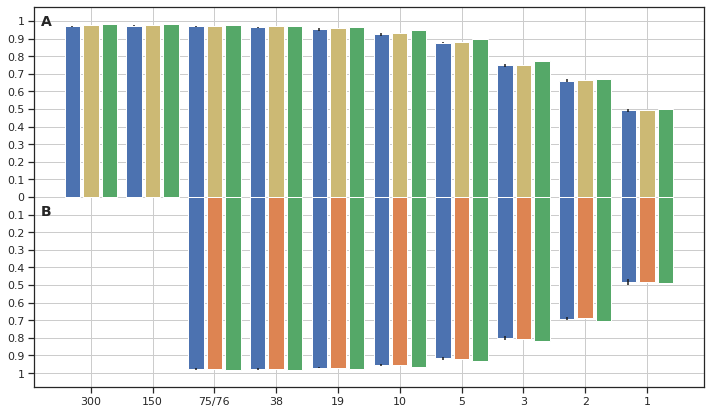

In [102]:
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(12,7))

xax1 = [str(i) for i in nfeats_ts]


# Pointwise features
ax.bar(x=np.arange(len(xax1))-0.3, height=cv_scores_ts_mean,
       yerr=cv_scores_ts_std, width=0.25, label='Cross Validation', color='b' )
ax.bar(x=np.arange(len(xax1)), height=oob_scores_ts, width=0.25, label='OOB', color='y' )
ax.bar(x=np.arange(len(xax1))+0.3, height=test_scores_ts, width=0.25, label='Test set',color='g' )



# Polynomial features

# adding 0s to y features
cv_scores_pf_mean_p = np.hstack((np.array([0,0]), cv_scores_pf_mean))
cv_scores_pf_std_p = np.hstack((np.array([0,0]), cv_scores_pf_std))
oob_scores_pf_p = np.hstack((np.array([0,0]), oob_scores_pf))
test_scores_pf_p  = np.hstack((np.array([0,0]), test_scores_pf))


ax.bar(x=np.arange(len(xax1))-0.3, height=-cv_scores_pf_mean_p,
       yerr=cv_scores_pf_std_p, width=0.25, label='Cross Validation' )
ax.bar(x=np.arange(len(xax1)), height=-oob_scores_pf_p, width=0.25, label='OOB' )
ax.bar(x=np.arange(len(xax1))+0.3, height=-test_scores_pf_p, width=0.25, label='Test set' )

# Changing xticks and yticks
ax.set(xticks=np.arange(len(xax1)), xticklabels=xax1, 
       yticks=np.arange(-1,1.001, 0.1), 
       yticklabels=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,0.1,0.2,0.3,0.4,0.5,0.6, 0.7,0.8,0.9,1])
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = '75/76'
ax.set_xticklabels(labels)

ax.grid()

# Text
ax.text(0.01,0.95,'A', fontweight='bold', fontsize=14,  transform=ax.transAxes)
ax.text(0.01,0.45,'B', fontweight='bold', fontsize=14,  transform=ax.transAxes)


plt.show()

In [101]:
np.arange(0,1,0.1).tolist()

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

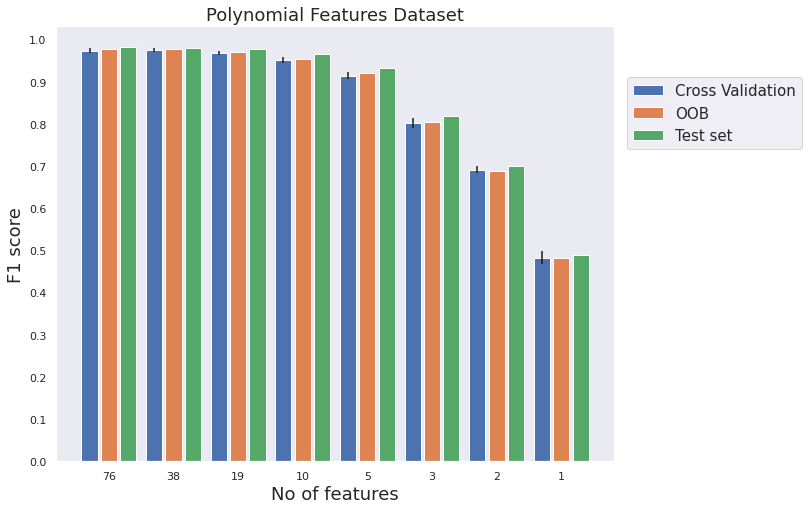

In [26]:
fig, ax = plt.subplots(figsize=(10,8))

X = [str(i) for i in nfeats_pf]
ax.bar(x=np.arange(len(X))-0.3, height=cv_scores_pf_mean,
       yerr=cv_scores_pf_std, width=0.25, label='Cross Validation' )
ax.bar(x=np.arange(len(X)), height=oob_scores_pf, width=0.25, label='OOB' )
ax.bar(x=np.arange(len(X))+0.3, height=test_scores_pf, width=0.25, label='Test set' )

plt.xticks(np.arange(len(X)), X)
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel("No of features", fontsize=18)
plt.ylabel("F1 score", fontsize=18)
plt.title("Polynomial Features Dataset", fontsize=18)

plt.legend(bbox_to_anchor=[1.01,0.9], prop={'size':15})
plt.grid()
plt.show()

In [50]:
def plot_fi_vs_f1(fi_data:list, ax):
    nfeats ,cv_scores_mean, cv_scores_std, oob_scores, test_scores = fi_data
    X = [str(i) for i in nfeats]
    ax.bar(x=np.arange(len(X))-0.3, height=cv_scores_mean,
        yerr=cv_scores_std, width=0.25, label='Cross Validation' )
    ax.bar(x=np.arange(len(X)), height=oob_scores, width=0.25, label='OOB' )
    ax.bar(x=np.arange(len(X))+0.3, height=test_scores, width=0.25, label='Test set' )

    ax.set_xticks(np.arange(len(X)))
    ax.set_xticklabels(X)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_xlabel("No of features")
    ax.set_ylabel("F1 score")
    #ax.title("Polynomial Features Dataset", fontsize=18)

    #plt.legend(bbox_to_anchor=[1.01,0.9], prop={'size':15})
    plt.grid()
    #lt.show()
    return ax

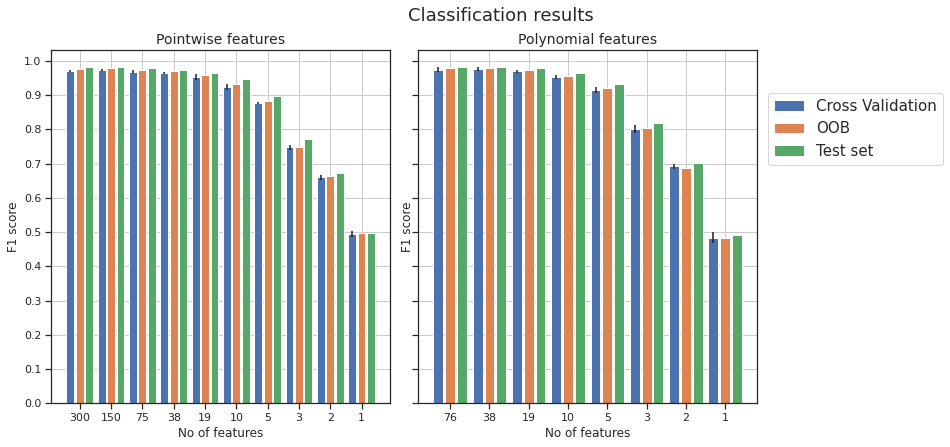

In [51]:
sns.set_style('ticks')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(14,7))

plot_fi_vs_f1(ts_reg_results, ax1)
plot_fi_vs_f1(pf_reg_results, ax2)
ax1.set_title("Pointwise features", fontsize=14)
ax2.set_title("Polynomial features", fontsize=14)

ax1.grid()
ax2.grid()
ax2.legend(bbox_to_anchor=[1.01,0.9], prop={'size':15})

plt.suptitle("Classification results", fontsize=18)
plt.tight_layout(rect=[0,0.1,0.95,0.95])
plt.show()

In [113]:
print(pf_fi_data[-2][1]) 
print()
print(pf_fi_data[-1][1])

1    10_10_0
0      5_1_1
Name: feature, dtype: object

1    5_1_1
Name: feature, dtype: object


In [114]:
fi_pf_top10 = get_fi(pf_fi_data[3][2],polyfeat[pf_fi_data[3][1]], "polyfeatures")
intervals = FeaturePlot(300).get_intervals([4,5,10])

Text(0.5, 1.0, 'Top 10 features from Polynomial Features')

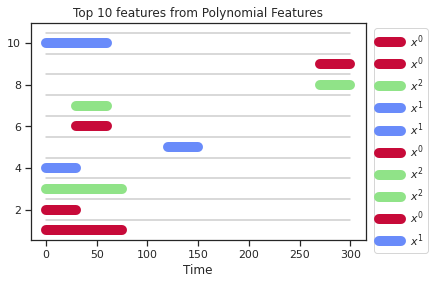

In [115]:
fig, ax = plt.subplots()
fi_df2plot(fi_pf_top10, 10, intervals, ax)
ax.legend(bbox_to_anchor=[1.01,1])

plt.title("Top 10 features from Polynomial Features")

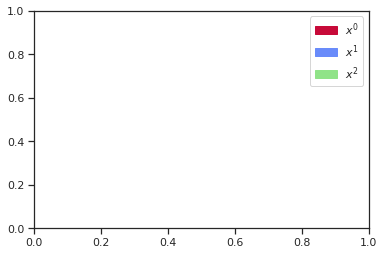

In [162]:
import matplotlib.patches as mpatches


fig, ax = plt.subplots()


color_arr = ['#c70a39','#698bfa','#90e388','y'

red_patch = mpatches.Patch(color=color_arr[0], label=r'$x^0$')
bl_patch = mpatches.Patch(color=color_arr[1], label=r'$x^1$')
green_patch = mpatches.Patch(color=color_arr[2], label=r'$x^2$')
plt.legend(handles=[red_patch, bl_patch, green_patch])

plt.show()



### FEatures from timeseries

In [135]:
fi_ts_10feat = get_fi(ts_fi_data[5][2], rscl_df[ts_fi_data[5][1]], 'timeseries')
fi_ts_10feat['timestamp'] = fi_ts_10feat['feature'].apply(lambda x : float(x[4:]))
fi_ts_10feat

,feature,fi,timestamp
0,feat51,0.117857,51.0
3,feat282,0.113698,282.0
2,feat52,0.107081,52.0
1,feat255,0.103790,255.0
5,feat285,0.102112,285.0
4,feat46,0.100257,46.0
8,feat48,0.094141,48.0
7,feat49,0.087592,49.0
9,feat277,0.087100,277.0
6,feat50,0.086372,50.0


In [128]:
fi_ts_top10 = get_fi(ts_fi_data[0][2],rscl_df[ts_fi_data[0][1]], "timeseries")
fi_ts_top10

,feature,fi
51,feat52,0.032981
48,feat49,0.024568
45,feat46,0.018940
47,feat48,0.018831
50,feat51,0.018475
...,...,...
200,feat201,0.000550
174,feat175,0.000528
178,feat179,0.000523
170,feat171,0.000494


In [129]:
fi_ts_top10['timestamp'] = fi_ts_top10['feature'].apply(lambda x : float(x[4:]))
fi_ts_top10

,feature,fi,timestamp
51,feat52,0.032981,52.0
48,feat49,0.024568,49.0
45,feat46,0.018940,46.0
47,feat48,0.018831,48.0
50,feat51,0.018475,51.0
...,...,...,...
200,feat201,0.000550,201.0
174,feat175,0.000528,175.0
178,feat179,0.000523,179.0
170,feat171,0.000494,171.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


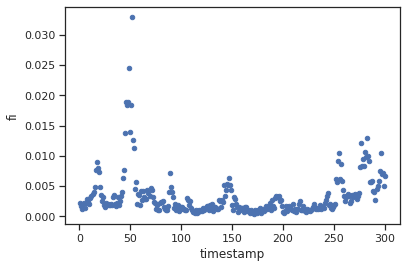

In [130]:
fi_ts_top10.plot.scatter('timestamp', 'fi', legend=None)

### Final Plot

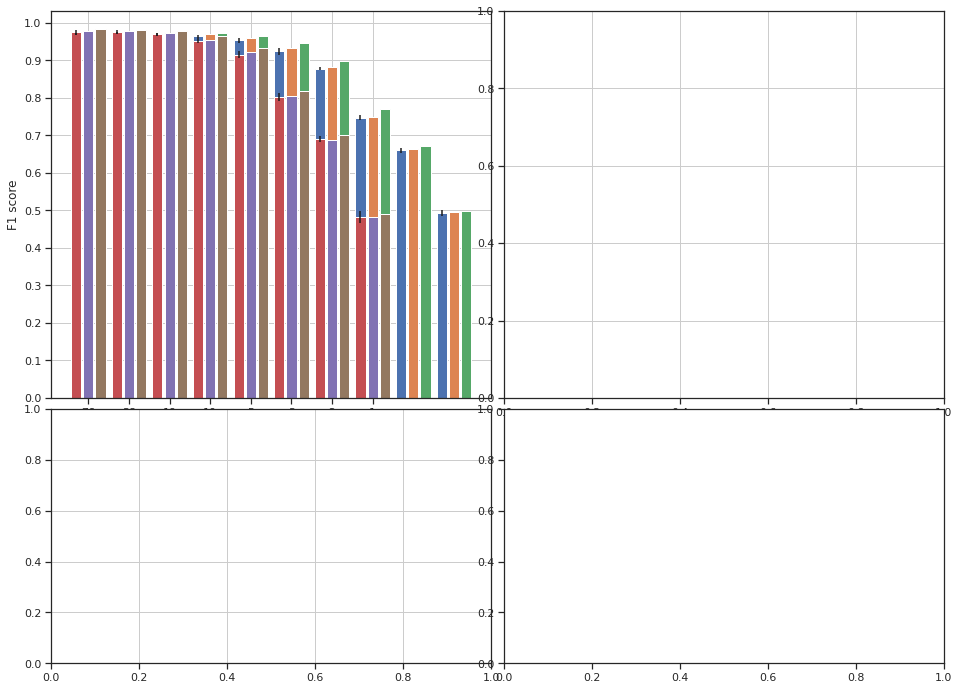

In [45]:
sns.set_style('ticks')

fig = plt.figure(figsize=(16, 12), constrained_layout=False)


ax = fig.add_gridspec(10, 12)
ax1 = fig.add_subplot(ax[0:6, 0:6])
ax2 = fig.add_subplot(ax[0:6, 6:12])
ax3 = fig.add_subplot(ax[6:10, 0:6])
ax4 = fig.add_subplot(ax[6:10, 6:12])


# for axes,label in zip([ax1,ax2,ax3,ax4],'A B C D'.split()):
#     axes.text(0.05, 0.95, label)# fontsize=16, fontweight='bold')#, va='top', ha='right')

plot_fi_vs_f1(ts_reg_results, ax1,pos)
plot_fi_vs_f1(pf_reg_results, ax1)
#ax2.legend(bbox_to_anchor=[1.01,0.9], prop={'size':15})

ax1.grid()
ax2.grid()
ax3.grid()

# ax3.plot(fi_ts_top10[:10].timestamp, fi_ts_top10[:10].fi, 'bo', markersize=15, alpha=0.4)
# ax3.set(xlim=[0,300], ylabel='Importance',title='Feature importance', xlabel='Time')

# fi_df2plot(fi_pf_top10[::-1], 10, intervals, ax4)
# ax4.get_legend().remove()
# ax4.set(ylabel="Ranking", title='Feature importance',
#         yticks=np.arange(1,11), yticklabels=np.arange(10,0,-1))

# ax1.text(-0.9,0.95,'A', fontsize=16, fontweight='bold')
# ax2.text(-0.9,0.95,'B', fontsize=16, fontweight='bold')


# plt.suptitle("Classification results", fontsize=24)
# plt.tight_layout(rect=[0,0,0.96,0.94])
# plt.show()

## Bar charts up and down

In [40]:
y = (np.random.randn(8) + 2)*5
y=np.hstack((np.array([0,0]),y))
len(y)

10

<BarContainer object of 10 artists>

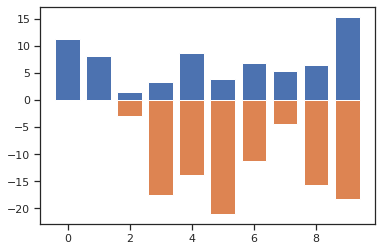

In [43]:
fig, ax = plt.subplots()

x = (np.random.randn(10) + 2)*5
y = (np.random.randn(8) + 2)*5
y=np.hstack((np.array([0,0]),y))
xax = np.arange(10)

ax.bar(xax,x)
ax.bar(xax,-y)

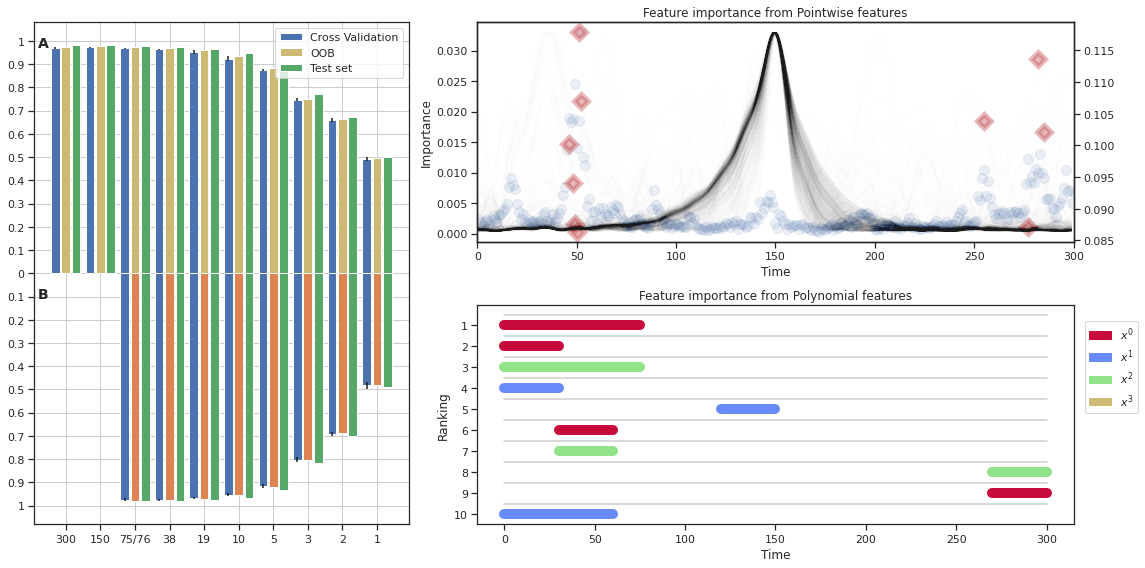

In [168]:
sns.set_style('ticks')

sns.set_style('ticks')

fig = plt.figure(figsize=(16,8))

ax = fig.add_gridspec(6, 5)
ax1 = fig.add_subplot(ax[:, 0:2])
ax2 = fig.add_subplot(ax[0:3,2:])
ax3 = fig.add_subplot(ax[3:6,2:])

xax1 = [str(i) for i in nfeats_ts]


### Left Panel


# Pointwise features
ax1.bar(x=np.arange(len(xax1))-0.3, height=cv_scores_ts_mean,
       yerr=cv_scores_ts_std, width=0.25, label='Cross Validation', color='b' )
ax1.bar(x=np.arange(len(xax1)), height=oob_scores_ts, width=0.25, label='OOB', color='y' )
ax1.bar(x=np.arange(len(xax1))+0.3, height=test_scores_ts, width=0.25, label='Test set',color='g' )
ax1.legend(loc="upper right")


# Polynomial features

# adding 0s to y features
cv_scores_pf_mean_p = np.hstack((np.array([0,0]), cv_scores_pf_mean))
cv_scores_pf_std_p = np.hstack((np.array([0,0]), cv_scores_pf_std))
oob_scores_pf_p = np.hstack((np.array([0,0]), oob_scores_pf))
test_scores_pf_p  = np.hstack((np.array([0,0]), test_scores_pf))


ax1.bar(x=np.arange(len(xax1))-0.3, height=-cv_scores_pf_mean_p,
       yerr=cv_scores_pf_std_p, width=0.25, label='Cross Validation' )
ax1.bar(x=np.arange(len(xax1)), height=-oob_scores_pf_p, width=0.25, label='OOB' )
ax1.bar(x=np.arange(len(xax1))+0.3, height=-test_scores_pf_p, width=0.25, label='Test set' )

# Changing xticks and yticks
ax1.set(xticks=np.arange(len(xax1)), xticklabels=xax1, 
       yticks=np.arange(-1,1.001, 0.1), 
       yticklabels=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,0.1,0.2,0.3,0.4,0.5,0.6, 0.7,0.8,0.9,1])
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[2] = '75/76'
ax1.set_xticklabels(labels)

ax1.grid()

# Text
ax1.text(0.01,0.95,'A', fontweight='bold', fontsize=14,  transform=ax1.transAxes)
ax1.text(0.01,0.45,'B', fontweight='bold', fontsize=14,  transform=ax1.transAxes)

### Right Panel

## Axes 2
ax2.plot(fi_ts_top10.timestamp, fi_ts_top10.fi, 'bo', markersize=10, alpha=0.1)
ax2.set(xlim=[0,300], ylabel='Importance',title='Feature importance from Pointwise features', xlabel='Time')

### create twin axis
ax2_copy = ax2.twinx()
ax2_copy.plot(fi_ts_10feat.timestamp, fi_ts_10feat.fi, 'rD', markersize=10, alpha=0.4, markeredgewidth=5)

### another axis for echo curve
ax2_echocopy = ax2.twinx()
for i in range(0,10500,10):
    ax2_echocopy.plot(rscl_data[i,:],'k',alpha=0.002)
ax2_echocopy.set_yticks([])



## Axes 3
fi_df2plot(fi_pf_top10[::-1], 10, intervals, ax3)
ax3.get_legend().remove()
ax3.set(ylabel="Ranking", title='Feature importance from Polynomial features',
        yticks=np.arange(1,11), yticklabels=np.arange(10,0,-1))

## setting up legend
color_arr = ['#c70a39','#698bfa','#90e388','y']

red_patch = mpatches.Patch(color=color_arr[0], label=r'$x^0$')
bl_patch = mpatches.Patch(color=color_arr[1], label=r'$x^1$')
green_patch = mpatches.Patch(color=color_arr[2], label=r'$x^2$')
yl_patch = mpatches.Patch(color=color_arr[3], label=r'$x^3$')
ax3.legend(handles=[red_patch, bl_patch, green_patch, yl_patch], bbox_to_anchor=[1.01,0.95])


plt.tight_layout()
plt.show()

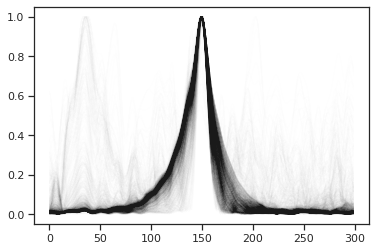

In [150]:
fig, ax = plt.subplots()

for i in range(0,10500,5):
    ax.plot(rscl_data[i,:],'k',alpha=0.002)